# Redes generativas adversarias condicionales

In [1]:
import torch
import tqdm
import torch.nn as nn
from torchvision import transforms, datasets
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import torch.optim as optim
import matplotlib.pyplot as plt

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Datos de entrenamiento

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5],std=[0.5])
    ])

dataset = datasets.MNIST(root='data', train=True, transform=transform, download=True)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

100%|██████████| 9.91M/9.91M [00:02<00:00, 4.18MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 133kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.27MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.29MB/s]


## GAN

### Redes neuronales

In [3]:
class Generator(nn.Module):

    def __init__(self, latent_dim=100, img_shape=(1, 28, 28)):
        super(Generator, self).__init__()
        self.img_shape = img_shape
        self.latent_dim = latent_dim
        self.init_size = img_shape[1] // 4

        self.l1 = nn.Sequential(
            nn.Linear(latent_dim, 128 * self.init_size * self.init_size)
        )

        self.conv_blocks = nn.Sequential(
            nn.BatchNorm2d(128),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),  # 7x7 -> 14x14.
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, self.img_shape[0], kernel_size=4, stride=2, padding=1),  # 14x14 -> 28x28.
            nn.Tanh()
        )

    def forward(self, z):
        batch_size = z.size(0)
        out = self.l1(z)
        out = out.view(batch_size, 128, self.init_size, self.init_size)  #  (batch_size, 128, 7, 7).
        img = self.conv_blocks(out)
        return img


class Discriminator(nn.Module):

    def __init__(self, img_shape=(1, 28, 28)):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(img_shape[0], 64, kernel_size=4, stride=2, padding=1),  # 28x28 -> 14x14.
            nn.LeakyReLU(0.2, inplace=True),  # 14x14 -> 7x7.
            nn.Conv2d(64, 96, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(96),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Flatten(),
            nn.Linear(96 * 7 * 7, 1),
            nn.Sigmoid()
        )

    def forward(self, img):
        validity = self.model(img)
        return validity

### Clase `GAN`

In [4]:
class GAN:

    def __init__(self, generator, discriminator):
        self.generator = generator
        self.discriminator = discriminator
        self.generator_optimizer = optim.Adam(self.generator.parameters(), lr=2e-4, betas=(0.5, 0.999))
        self.discriminator_optimizer = optim.Adam(self.discriminator.parameters(), lr=2e-4, betas=(0.5, 0.999))

    def train(self, dataloader, epochs):

        self.generator.to(DEVICE)
        self.discriminator.to(DEVICE)

        D_losses, G_losses = [], []

        try:
            progressbar = tqdm.trange(epochs)
            for epoch in progressbar:
                for x_true, _ in dataloader:

                    # Datos de entrenamiento:
                    x_true = x_true.to(DEVICE)
                    z_fake = torch.randn([len(x_true), self.generator.latent_dim], device=DEVICE)
                    x_fake = self.generator(z_fake)

                    # Entrenamiento discriminador:
                    loss_y1 = torch.log(self.discriminator(x_true)).mean(dim=0)
                    loss_y0 = torch.log(1 - self.discriminator(x_fake.detach())).mean(dim=0)
                    loss_discriminator = - 1/2 * (loss_y1 + loss_y0)
                    self.discriminator_optimizer.zero_grad()
                    loss_discriminator.backward()
                    self.discriminator_optimizer.step()

                    # Entrenamiento generador:
                    loss_generator = - 1/2 * torch.log(self.discriminator(x_fake)).mean(dim=0)
                    self.generator_optimizer.zero_grad()
                    loss_generator.backward()
                    self.generator_optimizer.step()

                    # Log:
                    progressbar.set_postfix(D_loss=loss_discriminator.item(), G_loss=loss_generator.item())
                    D_losses.append(loss_discriminator.item())
                    G_losses.append(loss_generator.item())

        except KeyboardInterrupt:
            print('Entrenamiento interrumpido.')

        plt.figure()
        plt.plot(D_losses, label='D_loss')
        plt.plot(G_losses, label='G_loss')
        plt.legend()
        plt.show()

    def generate(self, n_samples=64):

        self.generator.eval()
        z = torch.randn(n_samples, self.generator.latent_dim).to(DEVICE)

        with torch.no_grad():
            samples = self.generator(z)

        return samples.cpu()

In [5]:
# Redes generadora y discriminadora:
generator = Generator()
discriminator = Discriminator()

# Clase GAN:
gan = GAN(generator, discriminator)

 50%|█████     | 5/10 [02:21<02:21, 28.30s/it, D_loss=0.184, G_loss=1.01]


Entrenamiento interrumpido.


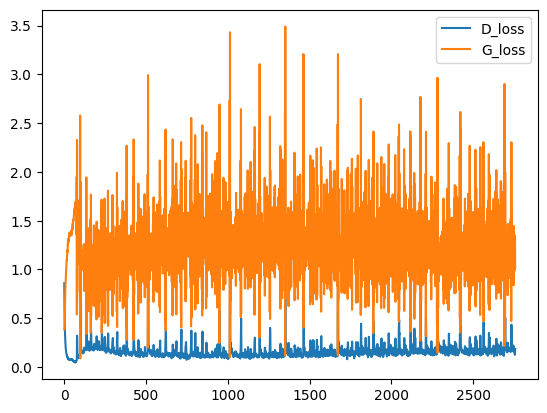

In [6]:
gan.train(dataloader, epochs=10)

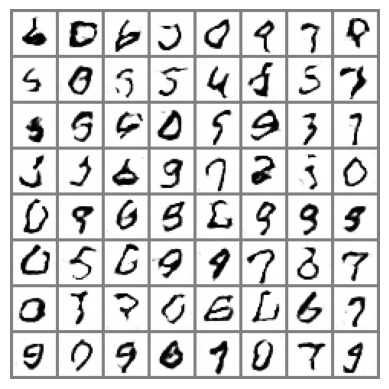

In [10]:
samples = gan.generate(64)

samples = make_grid(samples).permute(1, 2, 0)
samples = (samples + 1) / 2
plt.imshow(1-samples.clip(0,1), cmap='gray')
plt.axis('off')
plt.show()

## GAN para `FashionMNIST`

### Datos de entrenamiento

In [11]:
fashion_dataset = datasets.FashionMNIST(root='data', train=True, transform=transform, download=True)
fashion_dataloader = DataLoader(fashion_dataset, batch_size=128, shuffle=True)

  0%|          | 0/50 [00:04<?, ?it/s, D_loss=0.187, G_loss=1.44]


Entrenamiento interrumpido.


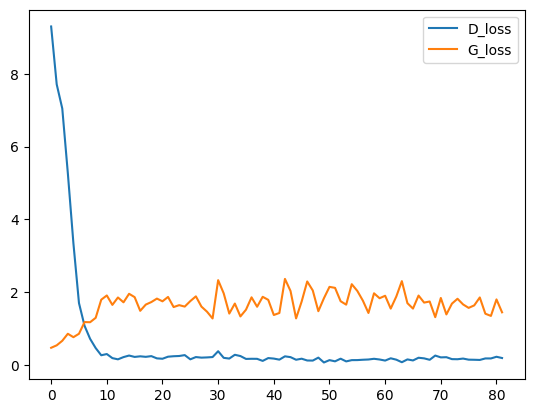

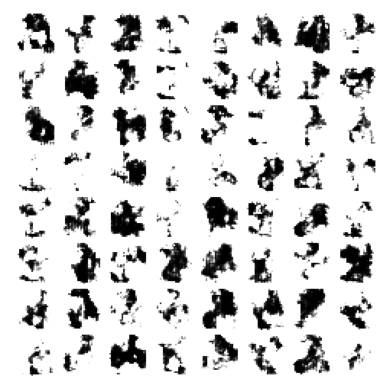

In [12]:
# Redes neuronales:
fashion_generator = Generator()
fashion_discriminator = Discriminator()

# Entrenamiento:
fashion_gan = GAN(generator, discriminator)
fashion_gan.train(fashion_dataloader, epochs=50)

# Generación:
fashion_samples = fashion_gan.generate(64)
fashion_samples = make_grid(fashion_samples).permute(1,2,0)
plt.imshow(1-fashion_samples.clip(0,1), cmap='gray')
plt.axis('off')
plt.show()